## Notes
- Add optional variance with random crops / horizontal flips
- For uniform images add variance on the lengths by randomly cropping a couple pixels on the height
- Add the ability to randomly insert larger images
- Use detectron for background separation and then process that separately with larger photos that gradually get smaller
    - downsample and then upsample to reduce the resolution to the smallest block for the images
    - Process the background horizontally
    - Process the foreground vertically
- sort the images by color so they can be filled in near their closest natural color

In [506]:
from PIL import Image, ImageEnhance, ExifTags, ImageFilter
from PIL.ExifTags import TAGS

from pillow_heif import register_heif_opener
import pillow_heif
register_heif_opener()

import numpy as np
from glob import glob
import random
from time import time
import os

In [507]:
main_img = "/Users/ben/Desktop/images.tmp/IvanHannah/4N2A7866.jpg"
img_dir = "/Users/ben/Desktop/images.tmp/IvanHannah"


os.chdir(img_dir)

In [519]:
# COLOR MODE: [background,foreground]
mode = ["bw","col"] #["bw","col"]

In [509]:
image_paths= []


suffixes = ["png","PNG","jpg","JPG","jpeg","JPEG","HEIC","heic"]

for suf in suffixes:
    for path in glob("*"+ suf):
        image_paths.append(path)
        
# Drop redundant/BAD images
drop_list = []

#["IMG_2277.JPG","IMG_2275.JPG","IMG_2276.JPG","IMG_2274.JPG","IMG_3522.jpg"]

for file in drop_list:
    try:
        image_paths.remove(file)
        print("REMOVED:",file)
    except:
        pass
    
len(image_paths)

238

In [510]:
def correct(tmp_img):
    try:
        for orientation in TAGS.keys() : 
            if ExifTags.TAGS[orientation]=='Orientation': break 
        exif=dict(tmp_img._getexif().items())

        if   exif[orientation] == 3 : 
            tmp_img=tmp_img.rotate(180, expand=True)
        elif exif[orientation] == 6 : 
            tmp_img=tmp_img.rotate(270, expand=True)
        elif exif[orientation] == 8 : 
            tmp_img=tmp_img.rotate(90, expand=True)
    except:
        pass
        
    return tmp_img

Original Dimesions: (1024, 1536)
Modified Dimesions: (1024, 1536)
Final Dimesions: (1000, 1500)
Collage Dimensions: [1700, 2200]


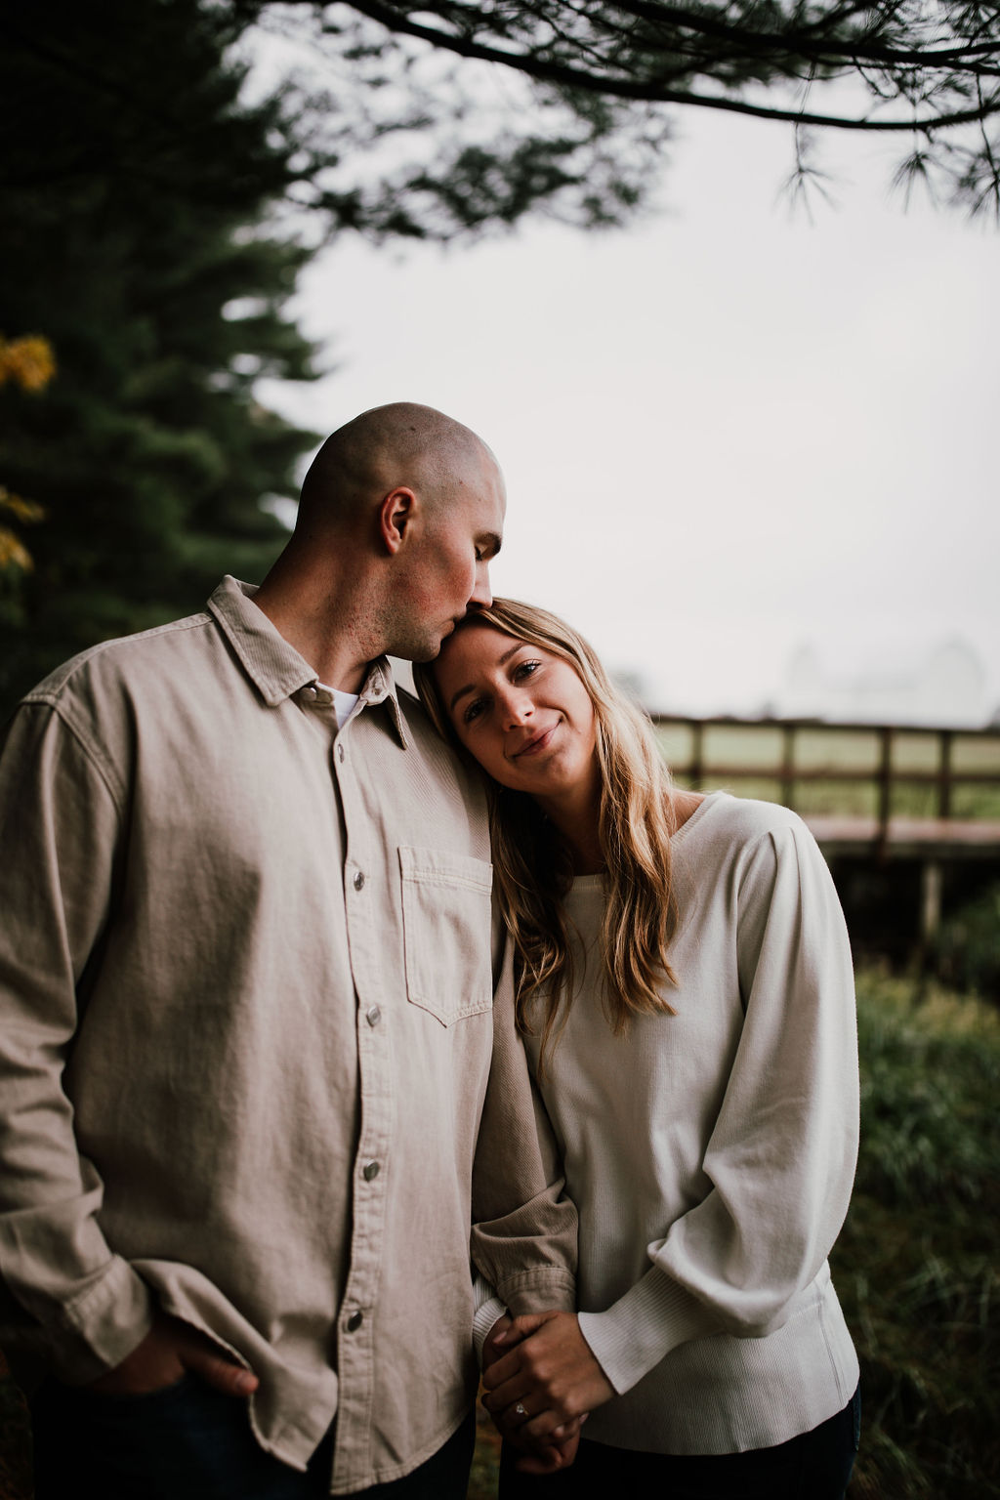

In [511]:
# Set the parameters for the collage
sub_img_width_dim = 50
padding = 700 # Add some padding on the horizontal
final_img_dim = [1000,1000]  # minimum
aspect_ratio = [2,3]

# load in the main image that the other photos will form
main_img = Image.open(main_img)

# correct the orientation
main_img = correct(main_img)
print("Original Dimesions:", main_img.size)

# Convert to RGB
main_img = main_img.convert("RGB")

# crop to the given size
crop_percent_left = 0
crop_percent_right = 0
crop_percent_top = 0
crop_percent_bottom = 0

crop_pixels_left = 0
crop_pixels_right = 0
crop_pixels_top = 0#200
crop_pixels_bottom = 0#800

main_img = main_img.crop((0 + crop_percent_left * main_img.size[0] + crop_pixels_left,
                          0+ crop_percent_top * main_img.size[1] + crop_pixels_top, 
                          main_img.size[0] - crop_percent_right * main_img.size[0] - crop_pixels_right, 
                          main_img.size[1] - crop_percent_bottom * main_img.size[1] - crop_pixels_bottom)) #left, up, right, bottom

#resize to the final dimensions
og_dims = list(main_img.size)
print("Modified Dimesions:", main_img.size)
scaling_factor = min(final_img_dim) / min(og_dims)
new_dims = [int(og_dims[0] * scaling_factor),
            int(og_dims[1] * scaling_factor)]
main_img = main_img.resize(new_dims)

print("Final Dimesions:", main_img.size)

# Add some padding to the ends
main_img_dim = [main_img.size[0] + padding, main_img.size[1] + padding]
print("Collage Dimensions:", main_img_dim)

main_img

In [495]:
img_list=[]
count = 0
for img_path in image_paths:
    if count % int(len(image_paths)/10)==0:
        print("{}/{} images loaded".format(count,len(image_paths)))
    img_list.append(Image.open(img_path))
    count +=1
print("Images loaded into starter array")

0/238 images loaded
23/238 images loaded
46/238 images loaded
69/238 images loaded
92/238 images loaded
115/238 images loaded
138/238 images loaded
161/238 images loaded
184/238 images loaded
207/238 images loaded
230/238 images loaded
Images loaded into starter array


In [512]:
collage_img = np.zeros((main_img_dim[1],main_img_dim[0],3))
cols_full = False
w_idx = 0
# random.seed(42)
count = 0

start_time = time()
img_list_copy=[]
while not cols_full:
    rows_full = False
    h_idx = 0
    while not rows_full:
        row_start_time = time()
        if len(img_list_copy) == 0:
            img_list_copy = img_list.copy()
            random.shuffle(img_list_copy)
        # load the image
#         img_path = paths_list.pop()
        count +=1
        tmp_img = img_list_copy.pop() #Image.open(img_path)
        
        tmp_img = correct(tmp_img)
        
        # check that its RGB
        if np.array(tmp_img).shape[2] == 4: 
#             print(img_path)
            #convert to RGB
            background = Image.new('RGBA', tmp_img.size, (255, 255, 255))
            tmp_img = Image.alpha_composite(background, tmp_img)
        
        # adjust the dimensions so that it fits the row
        w_dim, h_dim = tmp_img.size
        h_dim = int(h_dim / w_dim * sub_img_width_dim)
        w_dim = sub_img_width_dim
        
        tmp_img = tmp_img.resize((w_dim,h_dim))
        
        # add variance to the height to account for batches of identical images
        height_var_adj = random.randint(0,h_dim//20)
        new_h_dim = h_dim-(2*height_var_adj)
        tmp_img = tmp_img.crop([0,height_var_adj,w_dim,h_dim-height_var_adj])
        
        # paste the black and white image to the collage
        collage_img[h_idx:h_idx+new_h_dim,w_idx:w_idx+w_dim] = np.array(tmp_img)[:,:,:3]
        
        
        # update the x index
        h_idx += new_h_dim
        if h_idx > main_img_dim[1]-padding+sub_img_width_dim:
            rows_full = True
            # print the progress
            current_epoch = w_idx//sub_img_width_dim+1
            total_epochs =  (main_img.size[0])//sub_img_width_dim + 1
            print("Columns {}/{} Complete in {} seconds. Estimated time remaining {}".format(
                current_epoch,
                total_epochs,
                round(time() - start_time,1),
                round((time() - start_time) * ((total_epochs - current_epoch)/current_epoch),1)))
            
            # update the y index
            w_idx += w_dim
            
            
    # update the index
    if w_idx >= main_img_dim[0]-padding+sub_img_width_dim:
        cols_full = True
            
print("unique images:",len(image_paths))               
print("images used:",count)        

Columns 1/21 Complete in 0.4 seconds. Estimated time remaining 7.9
Columns 2/21 Complete in 0.8 seconds. Estimated time remaining 7.2
Columns 3/21 Complete in 1.1 seconds. Estimated time remaining 6.8
Columns 4/21 Complete in 1.5 seconds. Estimated time remaining 6.4
Columns 5/21 Complete in 1.9 seconds. Estimated time remaining 6.0
Columns 6/21 Complete in 2.2 seconds. Estimated time remaining 5.6
Columns 7/21 Complete in 2.6 seconds. Estimated time remaining 5.2
Columns 8/21 Complete in 2.9 seconds. Estimated time remaining 4.8
Columns 9/21 Complete in 3.3 seconds. Estimated time remaining 4.4
Columns 10/21 Complete in 3.7 seconds. Estimated time remaining 4.0
Columns 11/21 Complete in 4.0 seconds. Estimated time remaining 3.6
Columns 12/21 Complete in 4.4 seconds. Estimated time remaining 3.3
Columns 13/21 Complete in 4.7 seconds. Estimated time remaining 2.9
Columns 14/21 Complete in 5.1 seconds. Estimated time remaining 2.6
Columns 15/21 Complete in 5.5 seconds. Estimated time rem

In [513]:
# Image.fromarray(collage_img.astype('uint8'), 'RGB')

(1000, 1500)


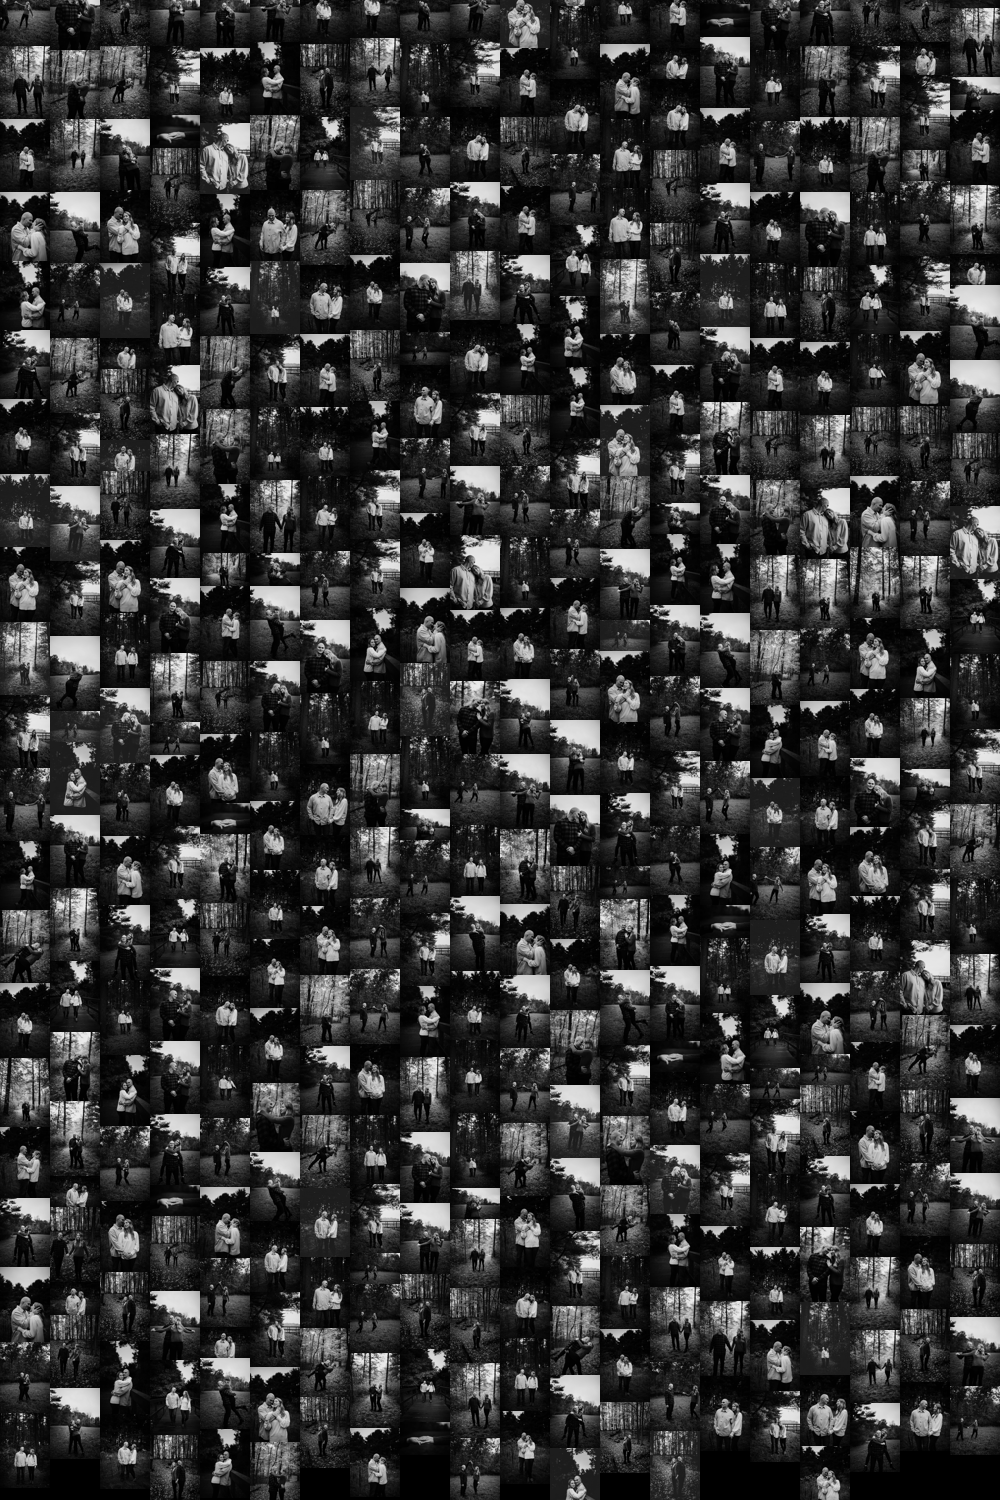

In [520]:
vertical_adjustment = 100
horizontal_adjustment = 0
collage_resized = np.array(collage_img)[vertical_adjustment:main_img.size[1]+vertical_adjustment,
                                        horizontal_adjustment:main_img.size[0]+horizontal_adjustment]
collage_background = Image.fromarray(collage_resized.astype('uint8'), 'RGB')
print(collage_background.size)

if mode[0] == "bw":
    # convert to black and white
    collage_background = ImageEnhance.Color(collage_background)
    collage_background = collage_background.enhance(0)  

collage_background

(1000, 1500)


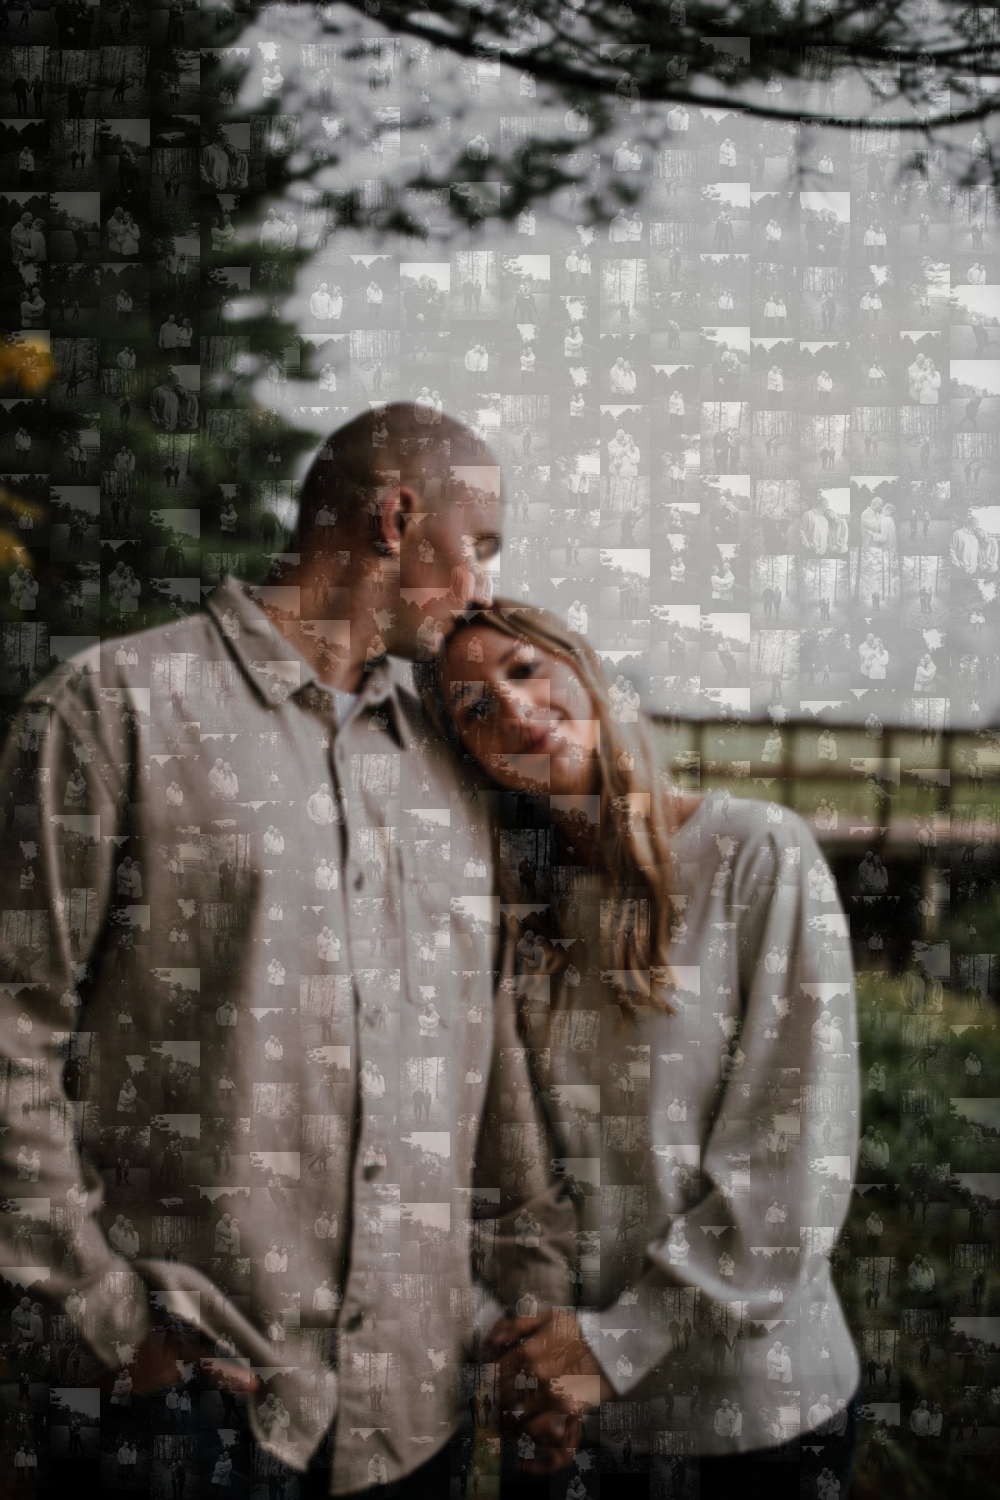

In [521]:
alpha= 0.25
blur = 2
sharpness = 1


main_img_adjusted = main_img.copy()

if mode[1]=='bw':
    # convert to black and white
    main_img_adjusted = ImageEnhance.Color(main_img_adjusted)
    main_img_adjusted = main_img_adjusted.enhance(0)

main_img_adjusted = main_img_adjusted.filter(ImageFilter.GaussianBlur(radius = blur))
main_img_adjusted = ImageEnhance.Sharpness(main_img_adjusted).enhance(sharpness)


final = Image.blend(main_img_adjusted, collage_background,alpha)
print(final.size)
final